## 목적
- sampling data를 통해 학습한 모델과 total data로 학습한 모델 간 성능에 차이가 있는가?
- 차이가 없다면 추후 실험에서도 sampling data를 사용(빠른 실험이 가능)

## 설계
- data
    - comm.user_input_matrix_for_upsell_monthly / 1월 데이터
    - trn_val / test 로 8:2 split
    - trn_val에서 label이 0인 데이터를 down-sampling 
- model
    - trn_val(or sample_trn_val)을 trn / val로 8:2 split
    - lightgbm 
- evaluation
    - 이전에 split한 test data 사용 
- code
    - total: total_lgbm.py
    - sample: sample_lgbm.py

In [30]:
df_total_result = pd.read_pickle('total_lgbm_tst_result.pkl')
df_sample_result = pd.read_pickle('sample_lgbm_tst_result.pkl')

## 결과
- 성능에 큰 차이가 없음
- 앞으로는 실험을 위해서 sampling 사용

In [3]:
67000/(3568020+67000)

0.018431810553999704

In [2]:
411926+3156094

3568020

acc  recall  precision  f1_score       auc
0  0.884901  0.9035   0.128498  0.224996  0.961122

pred: 1  pred: 0
true: 1    60736     6487
true: 0   411926  3156094

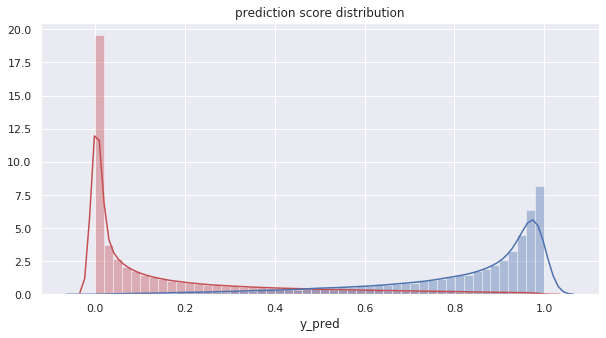

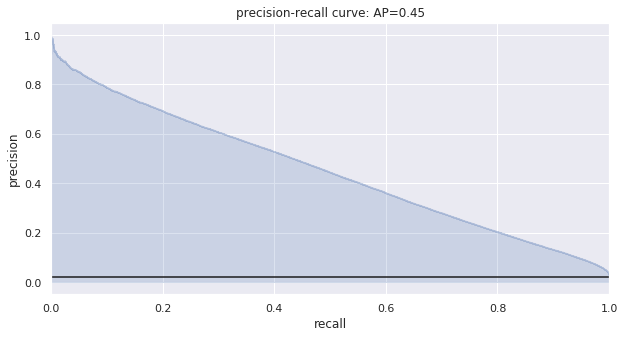

In [53]:
show_results(df_sample_result)

acc    recall  precision  f1_score       auc
0  0.885188  0.902191   0.128644  0.225179  0.960655

pred: 1  pred: 0
true: 1    60648     6575
true: 0   410794  3157226

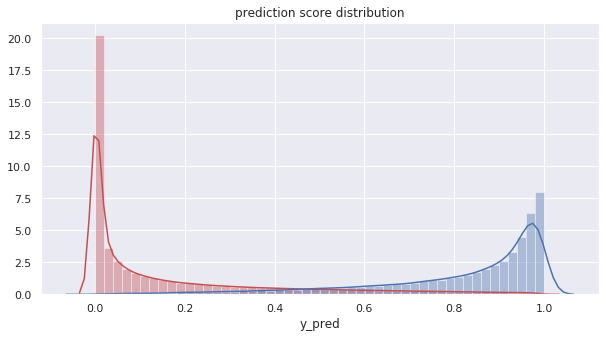

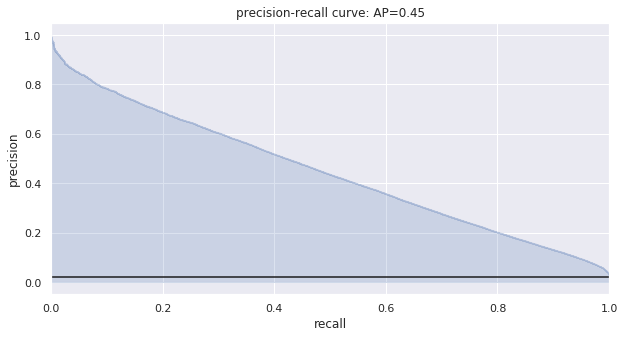

In [54]:
show_results(df_total_result)

## [NEW] 실험 재설계
- 기존에 다른건 동일, 학습/테스트 데이터 변경

In [1]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

In [2]:
from sm_utils import sampling, evaluate, show_results, save_model, load_model

/home/dmig/py_libs/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
x_trn = pd.read_pickle('../data/x_trn.pkl')
y_trn = pd.read_pickle('../data/y_trn.pkl')

x_val = pd.read_pickle('../data/x_test.pkl')
y_val = pd.read_pickle('../data/y_test.pkl')

x_tst = pd.read_pickle('../data/real_x_test.pkl')
y_tst = pd.read_pickle('../data/real_y_test.pkl')

In [5]:
print('x_trn: ', x_trn.shape)
print('y_trn: ', y_trn.shape)

print('x_val: ', x_val.shape)
print('y_val: ', y_val.shape)

print('x_tst: ', x_tst.shape)
print('y_tst: ', y_tst.shape)

x_trn:  (18176215, 79)
y_trn:  (18176215, 1)
x_val:  (3635243, 79)
y_val:  (3635243, 1)
x_tst:  (18580984, 79)
y_tst:  (18580984, 1)


In [10]:
feature_cols = list(x_trn.columns)

In [8]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 64,
    'learning_rate': 0.05,
    'num_threads': 60,
}

In [11]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

In [12]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=2000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.907507	valid_1's auc: 0.906914
[100]	training's auc: 0.92438	valid_1's auc: 0.923967
[150]	training's auc: 0.934434	valid_1's auc: 0.934141
[200]	training's auc: 0.940381	valid_1's auc: 0.940195
[250]	training's auc: 0.944397	valid_1's auc: 0.944273
[300]	training's auc: 0.947594	valid_1's auc: 0.947516
[350]	training's auc: 0.950051	valid_1's auc: 0.950001
[400]	training's auc: 0.952012	valid_1's auc: 0.951984
[450]	training's auc: 0.953339	valid_1's auc: 0.953311
[500]	training's auc: 0.954533	valid_1's auc: 0.954495
[550]	training's auc: 0.955819	valid_1's auc: 0.955788
[600]	training's auc: 0.956555	valid_1's auc: 0.956542
[650]	training's auc: 0.957396	valid_1's auc: 0.957385
[700]	training's auc: 0.958353	valid_1's auc: 0.958332
[750]	training's auc: 0.9592	valid_1's auc: 0.959181
[800]	training's auc: 0.959924	valid_1's auc: 0.959906
[850]	training's auc: 0.960788	valid_1's auc: 0.960778
[900]	

acc    recall  precision  f1_score       auc
0  0.88899  0.724675   0.147057  0.244499  0.899839

pred: 1   pred: 0
true: 1   333768    126808
true: 0  1935875  16184533

feature          desc  importance
44     avg_subscription_period  평균 요금제 변경 주기       14540
49               real_avg_arpu       평균 ARPU       12074
5              svc_scrb_period           NaN       11382
6            last_equip_period           NaN        9710
46             real_arpu_bf_m1       순수 ARPU        7191
48             real_arpu_bf_m3       순수 ARPU        5259
7                  bas_fee_amt        요금제 가격        5054
47             real_arpu_bf_m2       순수 ARPU        4903
1                          age            나이        4043
45            avg_chg_duration      평균 기변 주기        2830
53            data_usage_ratio           NaN        2761
8              bas_ofr_data_gb           NaN        2676
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율        2498
50           bf_m3_fee_chg_cnt  요금제 변경 횟수 피쳐        2440
9                  eqp_out_prc        단말 출고가        2311
3              mng_nice_cb_scr     나이스 신용 점수        2037
26      data_usage_in_gb_bf_m0           NaN        1953
78                     channel      요금제 가입채널        1881
28      data_usage_in_gb_bf_m2     총 데이터 사용량        1859
27      data_usage_in_gb_bf_m1     총 데이터 사용량        1832

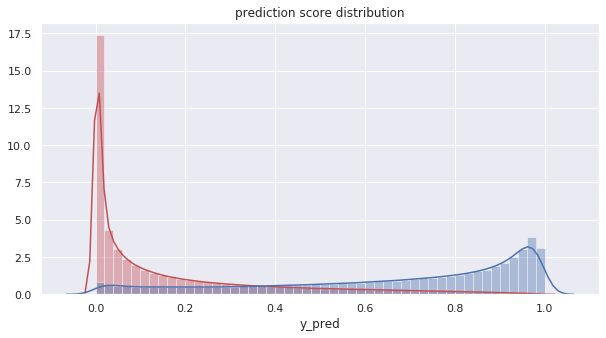

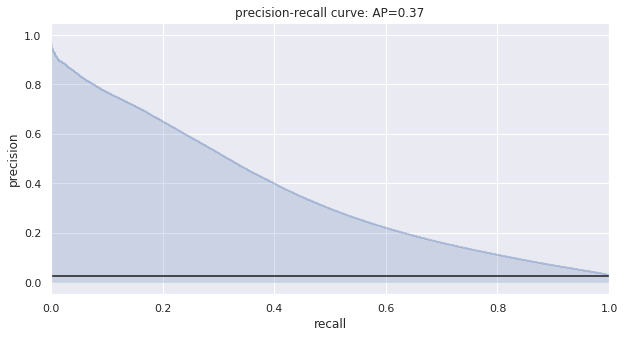

elapsed time:  304.7796001434326


In [13]:
t1 = time.time()
lgb_result_dict = evaluate(x_tst, y_tst.label.values, clf, 'lgb')
print('elapsed time: ', time.time()-t1)

### NEW 결과
- 성능은 약간의 차이가 있음(auprc 3%)
- 속도는 sampling이 훨신 빠름(13분 20초 vs 1시간 15분)
- 실험은 sampling으로 하고, 최종 production은 전수로 하는게 좋음